In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmasher as cmr
import numpy as np 
import os 
import matplotlib
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from astropy.io import ascii
from matplotlib import rc
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import os
dir = os.getenv("DATADIR")
plt.style.use(dir+'bl.mplstyle')
rcParams["mathtext.fontset"] = 'cm'

#########################
# Galaxy dependent vars #
#########################



lmc = {'zams_file':dir+'1_Models/ZAMS/ZAMS_Z0.006_ABmag.txt',
       'distance':50e3,
       'catalog':pd.read_csv(dir+'0_SUMS_Catalogs/CompleteCatalog/Crossmatched/lmc_step5_crossmatch.csv'),}

smc = {'zams_file':dir+'1_Models/ZAMS/ZAMS_Z0.002_ABmag.txt',
       'distance':60.6e3,
       'catalog':pd.read_csv(dir+'0_SUMS_Catalogs/CompleteCatalog/Crossmatched/smc_step5_crossmatch.csv'),}

# Convert catalog magnitudes back to vega 
ref = pd.read_csv(dir+'0_SUMS_Catalogs/Reference/ExtinctionAndVega2AB.csv')
for dict in [lmc,smc]:
    df = dict['catalog']
    for uvfilter in ['uvw2','uvm2','uvw1','U','B','V','I']:	
        df.loc[:,uvfilter] = df[uvfilter] - ref.loc[ref['filter'] == uvfilter.upper(),'Vega to AB'].values[0]

# Get simbad catalog, requiring things matched to within 0.5"
for dict in [lmc,smc]:
    dict['simbad'] = dict['catalog'][dict['catalog']['simbad_match_distance'] < 0.5].copy().reset_index(drop=True)

#############
# Functions #
#############

def Absolute_to_Apparent(AbsoluteMag,distance):
    return AbsoluteMag + 5 * (np.log10(distance/10))

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

grey_cmap = truncate_colormap(plt.get_cmap('Greys'), 0.55, 0.95)

def density(savename,df,uv_name,optical_name,size=100000):
    # Get rows where both columns exist
    rf = df[np.isfinite(df[uv_name]) & np.isfinite(df[optical_name])].reset_index(drop=True)
    # Get X and Y values
    x = (rf[uv_name] - rf[optical_name]).values
    y = rf[uv_name].values
    # Randomly sample to reduce computation time 
    random_index = np.random.choice(rf.shape[0],size,replace=False)
    x = x[random_index]
    y = y[random_index]
    # Top cat styling for bulk of points 
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy)(xy)
    index = z.argsort()
    x, y, z = np.array(x)[index], np.array(y)[index], np.array(z)[index]
    # Convert dict to df 
    dict = {'x':x,'y':y,'z':z}
    df = pd.DataFrame(dict)
    # Save data
    df.to_csv(savename,index=False)
    return df
def density_scatter( x , y, ax = None, fig=None, sort = True, bins = 10, **kwargs )   :
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    return x,y,z
########
# ZAMS #
########
def Absolute_to_Apparent(AbsoluteMag,distance):
    return AbsoluteMag + 5 * (np.log10(distance/10))
def create_zams(zams_file,distance):
    # Import Zams Model 
    zams = pd.read_csv(zams_file,sep=r'\s+',comment='#')
    # Get the columns we need 
    cols = ['Minit','UVW2_spec','UVM2_spec','UVW1_spec','U_spec','B_spec','V_spec','I_spec']
    zams = zams[cols]
    # Convert to apparent magnitudes
    for col in cols[1:]:
        zams[col] = Absolute_to_Apparent(zams[col],distance)
    # Rename columns
    new_cols = ['m','uvw2','uvm2','uvw1','u','b','v','i']
    zams.columns = new_cols
    return zams
def threshold_plot(ax, x, y, threshv, color, overcolor):
    cmap = ListedColormap([color, overcolor])
    norm = BoundaryNorm([np.min(y), threshv, np.max(y)], cmap.N)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(y)

    ax.add_collection(lc)
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y)*1.1, np.max(y)*1.1)
    return lc

lmc['zams'] = create_zams(lmc['zams_file'],lmc['distance'])
smc['zams'] = create_zams(smc['zams_file'],smc['distance'])

############################
# Print Otype and Spectype #
############################
o_types = ['WR','BSG/YSG','RSG','HMXB','Be','YSO','RGB/AGB','PN','RR Lyrae','Cepheid','Delta Scuti']
o_type_labels = ['WR','BSG/YSG','RSG','HMXB','Be','YSO','RGB/AGB','PN','RR Lyrae','Cepheid',r'$\delta$ Scuti']

# Sp Type 
spec_cols = ['O','B','A','F','G','K','M','W','C','D']
for label,dict in zip(['lmc','smc'],[lmc,smc]):
    print(label.upper())
    df = dict['simbad']
    # SPEC TYPE
    for typesp in spec_cols:
        n_group = df[df['simbad_sptype'] == typesp].shape[0]
        print(f'{typesp} type: ', n_group)
        df.loc[df.simbad_sptype.str.startswith(typesp),'simbad_group_sptype'] = typesp
    print(' ')

    # O TYPE
    for otype in o_types:
        n_group = df[df['simbad_group'] == otype].shape[0]
        print(f'{otype}: ', n_group)
    print(' ')
    
    

LMC
O type:  459
B type:  930
A type:  104
F type:  64
G type:  60
K type:  102
M type:  197
W type:  45
C type:  75
D type:  12
 
WR:  44
BSG/YSG:  47
RSG:  92
HMXB:  3
Be:  11
YSO:  92
RGB/AGB:  128
PN:  42
RR Lyrae:  391
Cepheid:  1250
Delta Scuti:  16
 
SMC
O type:  133
B type:  1304
A type:  265
F type:  103
G type:  118
K type:  163
M type:  27
W type:  6
C type:  56
D type:  3
 
WR:  6
BSG/YSG:  99
RSG:  116
HMXB:  81
Be:  104
YSO:  22
RGB/AGB:  68
PN:  6
RR Lyrae:  50
Cepheid:  1173
Delta Scuti:  5
 


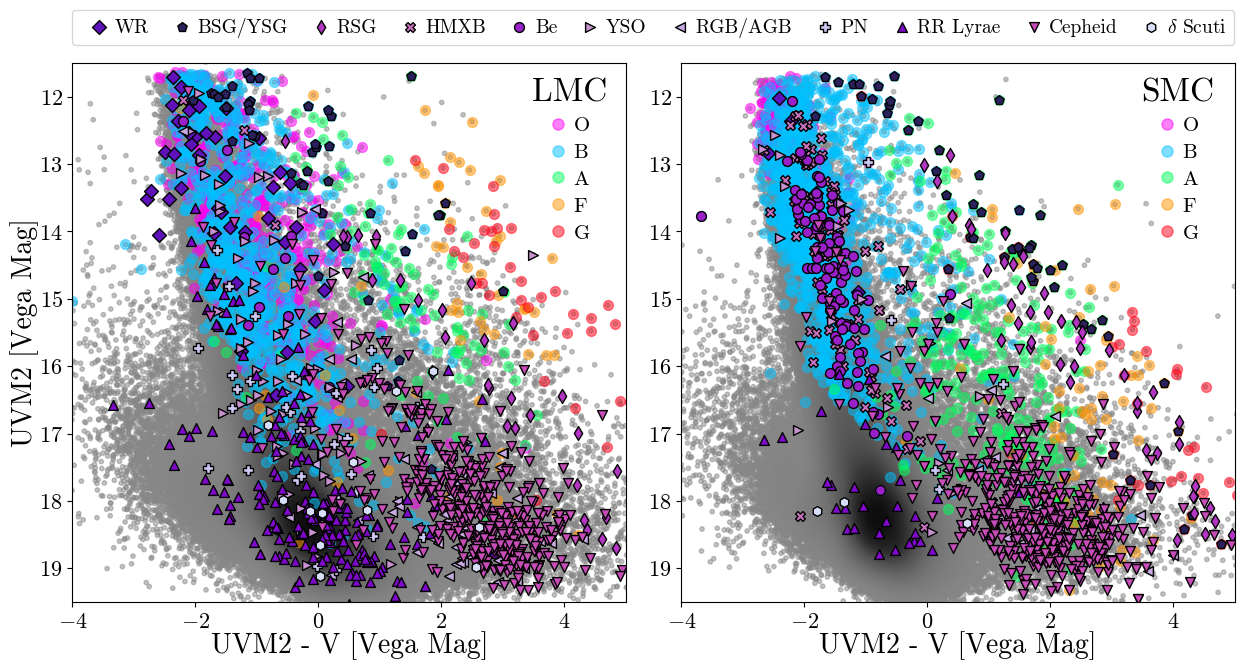

In [23]:
cm_o = [[0.37168725, 0.07244065, 0.72397518, 1.        ], # WR
       [0.16751926, 0.13433168, 0.36611899, 1.        ], # BSG/YSG
       [0.70171345, 0.21005419, 0.76310873, 1.        ], # RSG
       [0.78847776, 0.45212273, 0.73995217, 1.        ], # HMXB
       [0.60335393, 0.13051994, 0.78883403, 1.        ], # Be
       [0.7837699 , 0.56751904, 0.8103119 , 1.        ], # YSO
       [0.78496997, 0.67168853, 0.8848119 , 1.        ], # RGB/AGB
       [0.7945109 , 0.77877713, 0.95342266, 1.        ], # PN
       [0.49940978, 0.0359492 , 0.79504459, 1.        ], # RR Lyrae
       [0.7838467 , 0.30241794, 0.72164512, 1.        ], # cepheid
       [0.84367394, 0.8724648 , 0.97014857, 1.        ]] # delta scuti

cmap = [[9.878673536761772844e-01, 0.000000000000000000e+00, 9.617652926476454311e-01, 1.000000000000000000e+00],
[0.000000000000000000e+00, 7.573556047820753090e-01, 1.000000000000000000e+00, 1.000000000000000000e+00],
[0.000000000000000000e+00, 1.000000000000000000e+00, 3.625004724974956738e-01, 1.000000000000000000e+00],
[1.000000000000000000e+00, 5.790446966917554006e-01, 0.000000000000000000e+00, 1.000000000000000000e+00],
[1.000000000000000000e+00, 0.000000000000000000e+00, 9.375000000000000000e-02, 1.000000000000000000e+00]]

rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

f, axes = plt.subplots(1,2,figsize=(15,7))

# Set axes limits and labels 
for ax in axes:
    ax.set_ylim(19.5,11.5)
    ax.set_xlim(-4.,5)
    ax.set_xlabel('UVM2 - V [Vega Mag]')
axes[0].set_ylabel('UVM2 [Vega Mag]')
plt.subplots_adjust(wspace=0.1)

# Plot all kdes
plot_kde = True
if plot_kde:
    for ax,cat in zip(axes,[lmc['catalog'],smc['catalog']]):
        cat = cat[np.isfinite(cat['uvm2']) & np.isfinite(cat['V'])].reset_index(drop=True)
        x = cat.uvm2 - cat.V
        y = cat.uvm2
        x,y,z=density_scatter(x,y,ax=ax,sort=True,bins = [30,30])
        ax.scatter(x,y,c=z,s=10,zorder=0,edgecolor=None,cmap=grey_cmap,alpha=0.5)

# Plot SIMBAD by Object Type 
ax = axes[0]

markers = ['D', # WR
           'p', # BSG/YSG
           'd', # RSG 
           'X', # HMXB
           'o', # Be
           '>', # YSO
           '<', # RGB/AGB
           'P', # PN
           '^', # RR Lyrae
           'v', # Cepheid
           'h'] # Delta Scuti

spec_types = ['O','B','A','F','G','K']
c = 0
for ax,cat in zip(axes,[lmc['simbad'],smc['simbad']]):
    # By object type 
    for otype_name, otype_label,color,marker in zip(o_types,o_type_labels,cm_o,markers):
        otype = cat[cat.simbad_group == otype_name]
        if c == 0:
            label = otype_label
        else:
            label = ""
        uv = otype['uvm2'] 
        optical = otype['V'] 
        ax.scatter(uv-optical,uv,s=50,edgecolor='black',facecolor=color,label=otype_label,zorder=2,marker=marker)

    # By spec type
    for spec, color in zip(spec_types,cmap):
        if c == 0:
            label = spec
        else:
            label = ""
        s = cat[cat.simbad_group_sptype == spec]
        uv = s['uvm2'] 
        optical = s['V']
        ax.scatter(uv-optical,uv,s=50,facecolor=color,label=label,zorder=1,alpha=0.5)
    c += 1


# Add lmc smc labels 
lx = 0.05
ly = 0.05
lx = 0.83
ly = 0.93
color = "gainsboro"
ecolor = [0.16751926, 0.13433168, 0.36611899, 1.        ]
axes[0].text(lx,ly,'LMC',transform=axes[0].transAxes,fontsize=24)
axes[1].text(lx,ly,'SMC',transform=axes[1].transAxes,fontsize=24)
n=11

# Top legend
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[:n],labels[:n],bbox_to_anchor=(-0.019, 1.015, 2.135, 0.), mode="expand", scatterpoints=1,ncol=len(handles[:n]),fontsize=14,labelspacing=0.1,handletextpad=-0.2)

# Bottom legend
x_top = 3.9
y_top = 12.4
w_x = -0.4
# - O
[ax.scatter(x_top,y_top,color=cmap[0],alpha=0.5) for ax in axes]
[ax.text(x_top+0.25,y_top+0.11,'O',fontsize=15) for ax in axes]
# - B
[ax.scatter(x_top,y_top-w_x,color=cmap[1],alpha=0.5) for ax in axes]
[ax.text(x_top+0.25,y_top+0.11-w_x,'B',fontsize=15) for ax in axes]
# - A
[ax.scatter(x_top,y_top-2*w_x,color=cmap[2],alpha=0.5) for ax in axes]
[ax.text(x_top+0.25,y_top+0.11-2*w_x,'A',fontsize=15) for ax in axes]
# - F
[ax.scatter(x_top,y_top-3*w_x,color=cmap[3],alpha=0.5) for ax in axes]
[ax.text(x_top+0.25,y_top+0.11-3*w_x,'F',fontsize=15) for ax in axes]
# - G
[ax.scatter(x_top,y_top-4*w_x,color=cmap[4],alpha=0.5) for ax in axes]
[ax.text(x_top+0.25,y_top+0.11-4*w_x,'G',fontsize=15) for ax in axes]

plt.savefig('sums_photometry.png',bbox_inches='tight',dpi=300)